## Notebook for spike sorting from .rhd data without using the Pipeline of mountainsort (mac channel has no pipeline)
Uses:
    - intan2kwik (https://github.com/zekearneodo/intan2kwik/blob/master/README.md)
    - mountainlab suite(https://github.com/flatironinstitute/mountainlab-js)
    - mountainsort https://github.com/flatironinstitute/mountainsort_examples/blob/master/README.md
    - mountainsort examples https://github.com/flatironinstitute/mountainsort_examples/blob/master/README.md
    
##### This one has the making of and the debugging of the conversion
##### The clean version with the package pipefinch is on rhd_mountain_no_pipeline_pkg.ipynb

In [1]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import intan2kwik

# mountainlab imports
from mountainlab_pytools import mlproc as mlp
from mountainlab_pytools import mdaio

import logging

# Setup the logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

logger.info('Logger set')

2018-09-18 18:22:16,623 - root - INFO - Logger set


In [2]:
os.environ['OMP_NUM_THREADS'] = '8'
os.environ['MKL_NUM_THREADS'] = '8'
os.environ['NUMEXPR_NUM_THREADS'] = '8'

### Session parameters and raw files

In [3]:
exp_base = os.path.abspath('/Users/zeke/experiment/')

file_sys = {'exp_base': os.path.abspath('/Users/zeke/experiment/')}

sess_par = {'bird': 'o3g3',
           'sess': 'awake_2017-09-08_2925',
           'rec': 0}

file_sys_defaults = {'exp_base': os.path.abspath('/data/experiment')}


def file_names(sess_par, file_sys=None):
    f_s = unroll_file_sys(file_sys_defaults, file_sys)    
    
    f_n = {}
    f_n['raw'] = os.path.join(f_s['raw'], bird)

In [4]:
raw_folder = os.path.join(exp_base, 'raw_data', 'neural', 'awake_20180908_2925')
glob.glob(os.path.join(raw_folder, '*.rhd'))

['/Users/zeke/experiment/raw_data/neural/awake_20180908_2925/raw_intan_180908_153446.rhd',
 '/Users/zeke/experiment/raw_data/neural/awake_20180908_2925/raw_intan_180908_151446.rhd',
 '/Users/zeke/experiment/raw_data/neural/awake_20180908_2925/raw_intan_180908_143446.rhd',
 '/Users/zeke/experiment/raw_data/neural/awake_20180908_2925/raw_intan_180908_155446.rhd',
 '/Users/zeke/experiment/raw_data/neural/awake_20180908_2925/raw_intan_180908_161446.rhd',
 '/Users/zeke/experiment/raw_data/neural/awake_20180908_2925/raw_intan_180908_145446.rhd',
 '/Users/zeke/experiment/raw_data/neural/awake_20180908_2925/raw_intan_180908_152446.rhd',
 '/Users/zeke/experiment/raw_data/neural/awake_20180908_2925/raw_intan_180908_150446.rhd',
 '/Users/zeke/experiment/raw_data/neural/awake_20180908_2925/raw_intan_180908_142446.rhd',
 '/Users/zeke/experiment/raw_data/neural/awake_20180908_2925/raw_intan_180908_154446.rhd',
 '/Users/zeke/experiment/raw_data/neural/awake_20180908_2925/raw_intan_180908_162446.rhd',

In [5]:
rhd_files = glob.glob(os.path.join(raw_folder, '*.rhd'))
rhd_files.sort()
pd_f = pd.DataFrame(rhd_files, columns=['f_path'])

pd_f['stamp'] = pd_f['f_path'].apply(lambda x: int(os.path.split(x)[-1].split('.')[0].split('_')[-1]))

# Select some of the files
sess_start = 0
sess_end = 144400
pd_session = pd_f.loc[(pd_f['stamp'] > sess_start) & (pd_f['stamp'] < sess_end), :]
pd_session.index.size

2

## RHD to binary and mda files

In [6]:
from intan2kwik.core.h5 import tables
from intan2kwik.core import reading
from intan2kwik.kwd import *

def rhd_rec_to_dict(rhd_file, chan_groups_wishlist):
    '''
    :param rhd_list: (list of strings) paths of files to include in this rec
    :param chan_groups_wishlist: (flat ndarray/list) channel groups to get from the rhd files
    :return: dictionary of np. arrays [n_samples, n_chans] with entry for every chan group
    '''
    # make the table
    # read the blocks and append them to the table
    # set the attributes of the table
    total_samples_in = 0
    total_samples_in_dig =0

    read_block = reading.read_data(rhd_file)

    # filter include groups, warn if a group wasn't in the data and remove it from the list
    include_chan_groups = []
    block_data = {}
    block_t = {}
    for g in chan_groups_wishlist:
        if '{}_data'.format(g) in read_block.keys():
            include_chan_groups.append(g)
        else:
            logger.warn('Channel data group {} is not in the recordings'.format(g))
    logger.info('include groups {}'.format(include_chan_groups))
    # The main data (neural chans and dac chans; from include_chans)
    for ch_grp in include_chan_groups:
        block_data[ch_grp] = (read_block['{}_data'.format(ch_grp)].astype(np.int32) - 32768).T
        block_t[ch_grp] = (read_block['t_{}'.format(ch_grp)].astype(np.int32) - 32768).T
    
    # The digital channels
    try:
        block_data['dig_in'] = read_block['board_dig_in_data'].T.astype(np.short)
        block_t['dig'] = read_block['t_dig'].reshape([-1, 1])
        has_digital_in = True
    except KeyError as k:
        logger.warn('No digital channels')
        has_digital_in = False

    return block_data, block_t
    

def folder_to_files(folder, board='auto'):
    logger.info('reading intan chans data across all of rec {0}'.format(folder))
    if board=='auto':
        board = which_board(folder)
    all_rhx_files = glob.glob(os.path.join(folder, '*.{}'.format(board)))
    all_rhx_files.sort()
    logger.info('Found {} .{} files to process'.format(len(all_rhx_files), board))
    return all_rhx_files
    

def intan_to_vin(all_rhx_files, dest_file_path, 
                 include_channels=['amplifier'], 
                 board='auto', 
                 dtype=np.int16, variant='bin', order='C'):
    """
    :param folder: (string) folder where the .rh? files are
    :param dest_file_path: (string) dest of the kw? files
    :param rec: (int)
    :param include_channels: (flat ndarray/list)
    :param board: (str) 'rhd' or 'rhs' for rhd2000 or rhs2000, 'auto' for detecting from extension
    :return:
    """
    # make the .kwd file
    # make the /recording/0 group
    # dump header to application data
    # use nummpy to help with the write arithmetics and chunking express
        
    # attributes from the header
    first_header = reading.read_intan_header(all_rhx_files[0])
    # logger.info('First header {}'.format(first_header))
    v_multipliers = [0.195, 50.354e-6]
    if first_header['eval_board_mode'] == 1:
        v_multipliers[1] = 152.59e-6
        
    # list all the chunk files:
    samples_in = 0
    logger.info('File type is {}'.format(variant))
    
    with open(dest_file_path, 'wb') as out_file:
        logger.info('Creating the output file '.format(dest_file_path))
        
        for i, rhx_file in enumerate(all_rhx_files):
            logger.info('File {}/{}'.format(i, len(all_rhx_files)))
            data_dict, t_dict = rhd_rec_to_dict(rhx_file, include_channels)
            amp_data = data_dict['amplifier'].astype(dtype)

            # Check what to do if is mda
            if variant == 'mda':
                logger.info('Target is mda file, overrriding order to Fortran')
                order = 'F'
                if i == 0:
                    print('is mda')
                    # write a 'dummy mda_header with the right number of dimensions'
                    # but the wrong number of elements
                    hdr = write_mda_hdr(amp_data, out_file)
                    
            out_file.write(amp_data.T.tobytes(order=order))
            samples_in += data_dict['amplifier'].shape[0]
        
        if variant == 'mda':
            hdr[3] = first_header['num_amplifier_channels']
            hdr[4] = samples_in
            update_mda_hdr(hdr, out_file)
    
    return first_header, samples_in
    

def intan_to_bin(all_rhx_files, dest_file_path, 
                 include_channels=['amplifier'], 
                 board='auto', 
                 dtype=np.int16, variant='bin', order='C'):
    """
    :param folder: (string) folder where the .rh? files are
    :param dest_file_path: (string) dest of the kw? files
    :param rec: (int)
    :param include_channels: (flat ndarray/list)
    :param board: (str) 'rhd' or 'rhs' for rhd2000 or rhs2000, 'auto' for detecting from extension
    :return:
    """
    # make the .kwd file
    # make the /recording/0 group
    # dump header to application data
        
    # attributes from the header
    first_header = reading.read_intan_header(all_rhx_files[0])
    # logger.info('First header {}'.format(first_header))
    v_multipliers = [0.195, 50.354e-6]
    if first_header['eval_board_mode'] == 1:
        v_multipliers[1] = 152.59e-6
        
    # list all the chunk files:
    samples_in = 0
    logger.info('File type is {}'.format(variant))
    
    with open(dest_file_path, 'wb') as out_file:
        logger.info('Creating the output file '.format(dest_file_path))
        
        for i, rhx_file in enumerate(all_rhx_files):
            logger.info('File {}/{}'.format(i, len(all_rhx_files)))
            data_dict, t_dict = rhd_rec_to_dict(rhx_file, include_channels)
            amp_data = data_dict['amplifier'].astype(dtype)
            # amp_data comes in [n_samp, n_ch] shape

            # Check what to do if is mda
            if variant == 'mda':
                logger.info('Target is mda file, overrriding order to Fortran')
                order = 'C'
                if i == 0:
                    print('is mda')
                    # write a 'dummy mda_header with the right number of dimensions'
                    # but the wrong number of elements
                    hdr = write_mda_hdr(amp_data.T, out_file)
                out_file.write(amp_data.reshape((amp_data.shape[1], amp_data.shape[0]), order=order).tobytes(order=order))
                    
            if variant=='bin':
                out_file.write(amp_data.tobytes(order=order))
            # for the .bin, c_style, this appends chunks to a [n_samp, n_ch]
            samples_in += data_dict['amplifier'].shape[0]
        
        if variant == 'mda':
            hdr[3] = first_header['num_amplifier_channels']
            hdr[4] = samples_in
            update_mda_hdr(hdr, out_file)
    
    return first_header, samples_in

mda_fun_dict = {'int16': mdaio.writemda16i,
               'int32': mdaio.writemda32i,
                'float16': mdaio.writemda,
               'float32': mdaio.writemda32}

mda_dt_codes = {'float32': -3,
               'int16': -4,
               'int32': -5,
               'uint16': -6,
               'double': -7,
               'uint32':-8}


def update_mda_hdr(hdr, file_ptr):
    #firs for debugging: read the current header
    file_ptr.seek(0)
    file_ptr.write(hdr.astype(np.int32).tobytes())
    print(hdr)


def write_mda_hdr(x, file_ptr):
    #the header has:
     # dtype code
     # dtype size in bytes
     # num of dimensions
        # dim 1
        #...
        # dim m
    dtype = x.dtype
    hdr = np.array([mda_dt_codes[dtype.name], dtype.itemsize, x.ndim])
    hdr = np.append(hdr, x.shape)
    print(hdr)
    
    file_ptr.write(hdr.astype(np.int32).tobytes())
    return hdr

def intan_to_mda(all_rhx_files, dest_file_path, dtype=np.int16):
    logger.info('Reading {} intan files of into mda file {}'.format(len(all_rhx_files), dest_file_path))
    # make intermediate binary file
    
    dest_folder, dest_file = os.path.split(dest_file_path)
    bin_file_path = os.path.join(dest_folder, dest_file.split('.')[0] + '.bin')
    logger.info('Making intermediate binary file (c-style) {}'.format(bin_file_path))
    intan_meta, samples_in = intan_to_bin(all_rhx_files, bin_file_path, include_channels=['amplifier'], dtype=dtype)
    n_neural_chans = intan_meta['num_amplifier_channels']
    logger.debug('Should have {} channels, {} samples'.format(n_neural_chans, samples_in))
    
    # read the binary to mmap and save it as the final file
    x = np.memmap(bin_file_path, dtype=dtype).reshape(-1, n_neural_chans)
    logger.info('Writing to {} mda file'.format(dest_file_path))
    
    if dtype == np.int16:
        dt = 'int16'
    elif dtype == np.int32:
        dt = 'int32'
    elif dtype == np.float32:
        dt = 'float32'
    else:
        raise NotImplementedError
    
    mda_fun_dict[dt](x.T, dest_file_path)
    #os.remove(bin_file_path)
    return intan_meta, samples_in
    

In [67]:
intan2kwik.kwd.which_board

<function intan2kwik.kwd.which_board(folder)>

### convert and view using direct concatenation to mda

In [34]:
rhd_list = pd_session['f_path'].values.tolist()[:2]

In [7]:
intan_meta, samples_in = intan_to_bin(rhd_list, os.path.join(raw_folder, 'rhd_concat.mda'), 
                                      variant='mda')
zhdr = mdaio.readmda_header(os.path.join(raw_folder, 'rhd_concat.mda'))
z = mdaio.readmda(os.path.join(raw_folder, 'rhd_concat.mda'))

2018-09-18 18:07:35,109 - intan2kwik.kwd - INFO - File type is mda
2018-09-18 18:07:35,138 - intan2kwik.kwd - INFO - Creating the output file 
2018-09-18 18:07:35,139 - intan2kwik.kwd - INFO - File 0/2
2018-09-18 18:07:35,140 - intan2kwik.intan.load_intan - INFO - Reading rhd intan file /Users/zeke/experiment/raw_data/neural/awake_20180908_2925/raw_intan_180908_142446.rhd
100%|██████████| 200004/200004 [00:24<00:00, 8070.79it/s]
2018-09-18 18:08:00,785 - intan2kwik.intan.load_intan - WARNING - Will disregard notch filter
2018-09-18 18:08:00,797 - intan2kwik.kwd - INFO - include groups ['amplifier']
2018-09-18 18:08:01,965 - intan2kwik.kwd - INFO - Target is mda file, overrriding order to Fortran


is mda
[      -4        2        2       17 12000240]


2018-09-18 18:08:02,841 - intan2kwik.kwd - INFO - File 1/2
2018-09-18 18:08:02,842 - intan2kwik.intan.load_intan - INFO - Reading rhd intan file /Users/zeke/experiment/raw_data/neural/awake_20180908_2925/raw_intan_180908_143446.rhd
100%|██████████| 200004/200004 [00:22<00:00, 8716.77it/s]
2018-09-18 18:08:26,540 - intan2kwik.intan.load_intan - WARNING - Will disregard notch filter
2018-09-18 18:08:26,550 - intan2kwik.kwd - INFO - include groups ['amplifier']
2018-09-18 18:08:27,507 - intan2kwik.kwd - INFO - Target is mda file, overrriding order to Fortran


[      -4        2        2       17 24000480]


(17, 24000480)


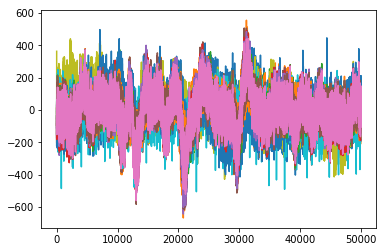

In [8]:
print(z.shape)
plt.figure()
plt.plot(z[:1000, :50000].T);

### convert and view using first .bin, then mda

In [14]:
intan_meta, samples_in = intan_to_mda(rhd_list, os.path.join(raw_folder, 'rhd_concat.mda'))

2018-09-18 13:47:11,204 - intan2kwik.kwd - INFO - Reading 2 intan files of into mda file /data/experiment/b8y14b/2018-06-29-0187/raw.mda
2018-09-18 13:47:11,206 - intan2kwik.kwd - INFO - Making intermediate binary file (c-style) /data/experiment/b8y14b/2018-06-29-0187/raw.bin
2018-09-18 13:47:11,212 - intan2kwik.kwd - INFO - File type is bin
2018-09-18 13:47:11,218 - intan2kwik.kwd - INFO - Creating the output file 
2018-09-18 13:47:11,219 - intan2kwik.kwd - INFO - File 0/2
2018-09-18 13:47:11,220 - intan2kwik.intan.load_intan - INFO - Reading rhd intan file /data/experiment/b8y14b/2018-06-29-0187/b8y14b_180625_081603.rhd
100%|██████████| 6588/6588 [00:01<00:00, 3739.30it/s]
2018-09-18 13:47:13,057 - intan2kwik.intan.load_intan - WARNING - Will disregard notch filter
2018-09-18 13:47:13,057 - intan2kwik.kwd - INFO - include groups ['amplifier']
2018-09-18 13:47:13,283 - intan2kwik.kwd - INFO - File 1/2
2018-09-18 13:47:13,284 - intan2kwik.intan.load_intan - INFO - Reading rhd intan fil

(32, 561600)


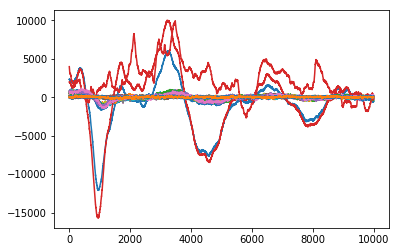

In [15]:
zhdr = mdaio.readmda_header(os.path.join(raw_folder, 'rhd_concat.mda'))
z = mdaio.readmda(os.path.join(raw_folder, 'rhd_concat.mda'))
print(z.shape)
z.shape
plt.figure()
plt.plot(z[:10000, :10000].T);

(110880, 32)


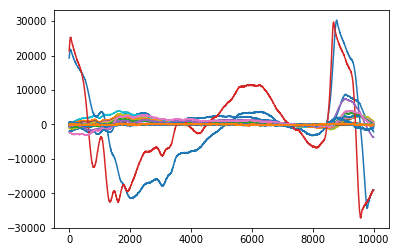

In [16]:
x = np.memmap(os.path.join(raw_folder, 'rhd_concat.bin'), order='F', dtype=np.int16).reshape(-1, 32)
print(x.shape)
plt.plot(x[:10000, :10000]);

## Scripts for sorting

In [21]:
## Dirty import of sorting helper functions from mountainsort exapmles
import sys
example_dir = os.path.abspath('/Users/zeke/repos/mountainlab-js/OLD/examples/spike_sorting/python_example/')
sys.path.append(example_dir)

import mountainsort4_v1 as ms4

### prep the files with their nice formats, locations and names


In [54]:
ss_folder = os.path.join('/Users/zeke/experiment/ss_data/', sess_par['bird'], sess_par['sess'])
out_folder = os.path.join(ss_folder, 'sort_out')

os.makedirs(ss_folder, exist_ok=True)
os.makedirs(ss_folder, exist_ok=True)


input_f_names = {'mda': 'raw.mda',
                 'params': 'params.json',
                 'geom': 'geom.csv'}

output_f_names ={'filt': 'filt.mda.prv',
                'pre': 'pre.mda.prv',
                 'firings': 'firings.mda',
                 'firings_curated': 'firings_curated.mda',
                 'cluster_metrics': 'cluster_metrics.json'
                }

file_paths = {k: os.path.join(ss_folder, v) for k,v in input_f_names.items()}
file_paths.update({k: os.path.join(out_folder, v) for k,v in output_f_names.items()})

#todo:
# meta and pars from intan files et al
s_f = 20000
ds_params = {'samplerate': s_f}

with open(file_paths['params'], 'w') as fp:
    json.dump(ds_params, fp)
    logger.info('Created session par files {}'.format(file_paths['params']))

#intan_meta, samples_in = intan_to_bin(rhd_list, file_paths['mda'], variant='mda')


2018-09-18 20:20:07,115 - intan2kwik.kwd - INFO - Created session par files /Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/params.json


In [43]:
file_paths

{'mda': '/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/raw.mda',
 'params': '/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/params.json',
 'geom': '/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/geom.csv',
 'filt': '/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/sort_out/filt.mda.prv',
 'pre': '/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/sort_out/pre.mda.prv',
 'firings': '/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/sort_out/firings.mda',
 'firigs_curated': '/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/sort_out/firings_curated.mda',
 'cluster_metrics': '/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/sort_out/cluster_metrics.json'}

In [36]:
# Bandpass
mlp.runProcess('ephys.bandpass_filter', 
               {'timeseries': file_paths['mda']}, {'timeseries_out': file_paths['filt']}, 
               {'samplerate': 20000, 'freq_min': 300, 'freq_max': 6000})



RUNNING: ml-run-process ephys.bandpass_filter --inputs timeseries:/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/raw.mda --parameters freq_max:6000 freq_min:300 samplerate:20000 --outputs timeseries_out:/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/filt.mda
[ Getting processor spec... ]
[ Checking inputs and substituting prvs ... ]
[ Computing process signature ... ]
[ Checking outputs... ]
[ Checking process cache ... ]
[ Process ephys.bandpass_filter already completed. ]
[ Done. ]


{'timeseries_out': '/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/filt.mda'}

In [29]:
## visualize the time series
os.system('ev-timeseries --timeseries{}'.format(file_paths['mda']))

0

In [23]:
ms4.read_dataset_params(ss_folder)

{'samplerate': 20000}

In [56]:
from importlib import reload
reload(ms4)

<module 'mountainsort4_v1' from '/Users/zeke/repos/mountainlab-js/OLD/examples/spike_sorting/python_example/mountainsort4_v1.py'>

In [49]:
ms4.sort_dataset(dataset_dir=ss_folder,output_dir=out_folder,adjacency_radius=-1,detect_threshold=3)

RUNNING: ml-run-process ephys.bandpass_filter --inputs timeseries:/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/raw.mda --parameters freq_max:6000 freq_min:300 samplerate:20000 --outputs timeseries_out:/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/sort_out/filt.mda.prv
[ Getting processor spec... ]
[ Checking inputs and substituting prvs ... ]
[ Computing process signature ... ]
[ Checking outputs... ]
[ Checking process cache ... ]
[ Process ephys.bandpass_filter already completed. ]
[ Creating output prv for timeseries_out ... ]
[ Done. ]
RUNNING: ml-run-process ephys.whiten --inputs timeseries:/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/sort_out/filt.mda.prv --parameters --outputs timeseries_out:/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/sort_out/pre.mda.prv
[ Getting processor spec... ]
[ Checking inputs and substituting prvs ... ]
Locating /Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/sort_out/filt.mda.prv ...
[ Comp

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [47]:
out_folder

'/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/sort_out'

In [57]:
ms4.automated_curation(firings=file_paths['firings'], 
                       cluster_metrics=file_paths['cluster_metrics'],
                       firings_out=file_paths['firings_curated'],
                       opts={})

RUNNING: ml-run-process ms4alg.create_label_map --inputs metrics:/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/sort_out/cluster_metrics.json --parameters --outputs label_map_out:/tmp/mountainlab-tmp/mountainlab/tmp_short_term/output_label_map_out_eb92531139390e974bf4b9d339f8c7e18b564a6c.prv
[ Getting processor spec... ]
[ Checking inputs and substituting prvs ... ]
[ Computing process signature ... ]
[ Checking outputs... ]
[ Checking process cache ... ]
[ Creating temporary directory ... ]
[ Preparing temporary outputs... ]
[ Initializing process ... ]
[ Running ... ] /Users/zeke/anaconda3/envs/mountain/bin/python3 /Users/zeke/anaconda3/envs/mountain/etc/mountainlab/packages/ml_ms4alg/curation_spec.py.mp ms4alg.create_label_map --metrics=/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/sort_out/cluster_metrics.json --label_map_out=/tmp/mountainlab-tmp/tempdir_e2c7d0d714_FtfUNT/output_label_map_out --_tempdir=/tmp/mountainlab-tmp/tempdir_e2c7d0d714_FtfUNT
Elapsed t

{'firings_out': '/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/sort_out/firings_curated.mda'}

In [53]:
file_paths

{'mda': '/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/raw.mda',
 'params': '/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/params.json',
 'geom': '/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/geom.csv',
 'filt': '/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/sort_out/filt.mda.prv',
 'pre': '/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/sort_out/pre.mda.prv',
 'firings': '/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/sort_out/firings.mda',
 'firigs_curated': '/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/sort_out/firings_curated.mda',
 'cluster_metrics': '/Users/zeke/experiment/ss_data/o3g3/awake_2017-09-08_2925/sort_out/cluster_metrics.json'}

In [ ]:
ms4.compute_cluster_metrics(*,timeseries,firings,metrics_out,samplerate,opts={})

In [30]:
output_dir = os.path.join(ss_folder, 'sort_out')
with Pipeline:
    ms4.sort_dataset(dataset_dir=ss_folder,output_dir=output_dir,adjacency_radius=-1,detect_threshold=3)

Output()

Finished pipeline.


In [ ]:
# viewing examples
ev-templates output/templates.mda.prv
ev-timeseries dataset/raw.mda.prv --firings output/firings.mda.prv --samplerate=30000
qt-mountainview --raw dataset/raw.mda.prv --filt output/filt.mda.prv --pre output/pre.mda.prv --samplerate 30000 --firings output/firings.mda.prv
